# 1. Project motivation

### From Life:
Breast cancer is the most fatal disease in women, so it is very important to detect symptoms of the disease and treat it promptly.

### From Technology: 
Deep learning is currently a very strong development direction of machine learning. We can use it in medicine with great results.

# 2. Dataset

### Breast Histopathology Images Dataset

Source: https://www.kaggle.com/paultimothymooney/breast-histopathology-images

### IDC
Invasive Ductal Carcinoma (IDC) is the most common subtype of all breast cancers. To assign an aggressiveness grade to a whole mount sample, pathologists typically focus on the regions which contain the IDC. As a result, one of the common pre-processing steps for automatic aggressiveness grading is to delineate the exact regions of IDC inside of a whole mount slide.

### Describe the dataset
- The original dataset consisted of 279 whole mount slide images of Breast Cancer (BCa) specimens scanned at 40x.
- 277,524 patches of size 50 x 50 were extracted (198,738 IDC negative and 78,786 IDC positive). 
- Each patch’s file name is of the format: uxXyYclassC.png — > example 10253idx5x1351y1101class0.png.
        + Where u is the patient ID (10253idx5);
        + X is the x-coordinate of where this patch was cropped from; 
        + Y is the y-coordinate of where this patch was cropped from; 
        + C indicates the class where 0 is non-IDC and 1 is IDC.

# 3. Project plan

### - Input
Dataset: Breast Histopathology Images Dataset

### - Model
Deep learning:
- ANN
- CNN
- CapsNet

### - Output
Results of diagnosis

#### Directory Structure

- Main Directory:
    + main/
        + Process_Data.ipynb
        + CNN.ipynb
        + ...
    + dataset/
        + 8863/
        + 9325/
        + ...
    + data_batch_train/
        + X_train_1.hdf5
        + ...
    + data_batch_valid/
        + ...
    + data_batch_test/
        + ...

# 4. Data processing

### 4.1. Import libraries

In [2]:
import os
import re
import numpy as np
import seaborn as sns
from skimage.io import imread
import cv2
from sklearn.model_selection import train_test_split

import pandas as pd
pd.set_option('display.max_colwidth', None)

import matplotlib.pyplot as plt
params = {
    'figure.figsize': (10, 10),
    'xtick.labelsize':'large',
    'ytick.labelsize':'large',
}
plt.rcParams.update(params)

In [3]:
data_dir = '../dataset'
folders = os.listdir(data_dir)

print('Number of patients: ' + str(len(folders)))

Number of patients: 279


### 4.2. Data initialization

In [4]:
regex_find_x = '_x.+_y'
regex_find_y = '_y.+_'

total_images = 0
patient_id = []
patient_x = []
patient_y = []
patient_path = []
patient_target = []

for i in folders:
    p_id = i
    
    for label in [0, 1]:
        p_path = data_dir + '/' + p_id + '/' + str(label)
        images = os.listdir(p_path)
        total_images += len(images)
        
        for i_path in images:
            image_path = p_path + '/' + i_path
            
            tmp_x = re.findall(regex_find_x, image_path)
            tmp_y = re.findall(regex_find_y, image_path)
            
            patient_id.append(int(p_id))
            patient_x.append(int(tmp_x[0][2:-2]))
            patient_y.append(int(tmp_y[0][2:-1]))
            patient_path.append(image_path)
            patient_target.append(int(label))
            
data_dict = {
    'patient_id': patient_id,
    'x': patient_x,
    'y': patient_y,
    'path': patient_path,
    'target': patient_target
}

In [5]:
data = pd.DataFrame(data = data_dict)

print('Number of images: ' + str(total_images))

Number of images: 277524


In [6]:
data.head(20)

,patient_id,x,y,path,target
0,15840,1001,751,../dataset/15840/0/15840_idx5_x1001_y751_class0.png,0
1,15840,2001,1251,../dataset/15840/0/15840_idx5_x2001_y1251_class0.png,0
2,15840,901,1051,../dataset/15840/0/15840_idx5_x901_y1051_class0.png,0
3,15840,101,1501,../dataset/15840/0/15840_idx5_x101_y1501_class0.png,0
4,15840,1301,651,../dataset/15840/0/15840_idx5_x1301_y651_class0.png,0
5,15840,2051,1001,../dataset/15840/0/15840_idx5_x2051_y1001_class0.png,0
6,15840,901,401,../dataset/15840/0/15840_idx5_x901_y401_class0.png,0
7,15840,1001,401,../dataset/15840/0/15840_idx5_x1001_y401_class0.png,0
8,15840,1451,951,../dataset/15840/0/15840_idx5_x1451_y951_class0.png,0
9,15840,2251,951,../dataset/15840/0/15840_idx5_x2251_y951_class0.png,0


### 4.3. Analyze and visualize data

#### Number of patches/patient

/home/trungluong1194/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


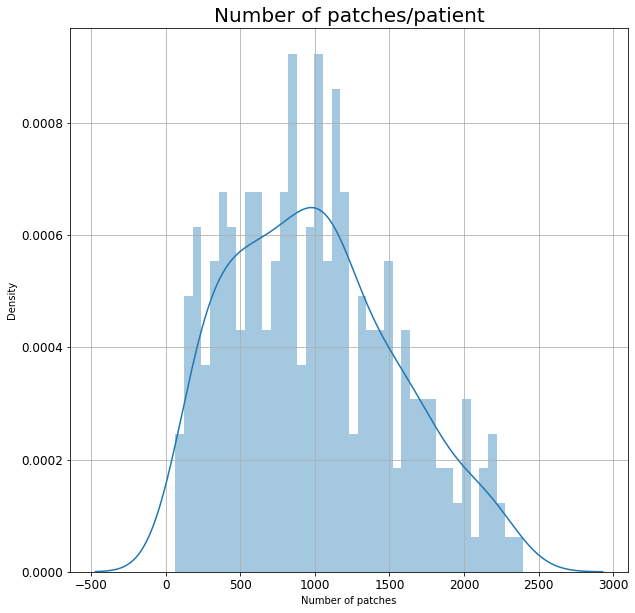

In [7]:
patch_each_patient = data.groupby('patient_id').target.size()

g = sns.distplot(patch_each_patient, bins=40)
g.set_xlabel('Number of patches')
g.set_ylabel('Density')
g.set_title('Number of patches/patient', fontsize=20)
g.grid()

/home/trungluong1194/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


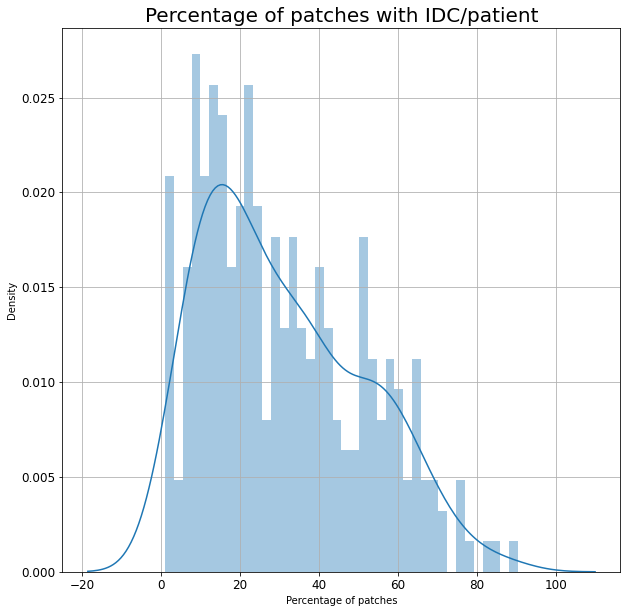

In [8]:
cancer_percentage = data.groupby('patient_id').target.value_counts() / data.groupby('patient_id').target.size()
cp = cancer_percentage.loc[:, 1] * 100

g = sns.distplot(cp, bins=40)
g.set_xlabel('Percentage of patches')
g.set_ylabel('Density')
g.set_title('Percentage of patches with IDC/patient', fontsize=20)
g.grid()

#### Percentage of patchs show IDC

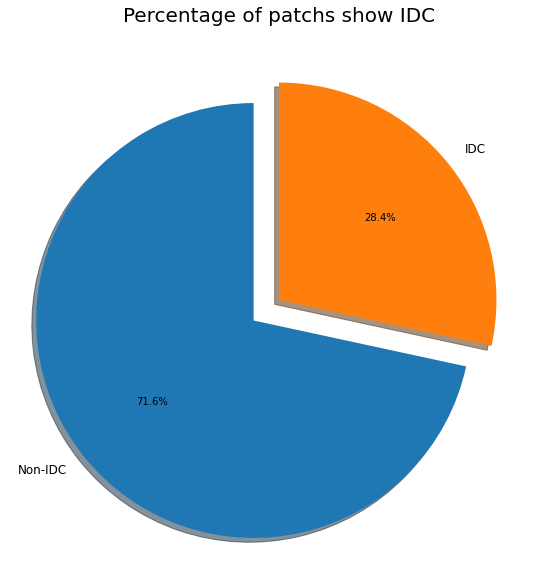

In [9]:
target_percentage = data.target.value_counts()
labels_tp = ['Non-IDC', 'IDC']
explode_tp = (0.15, 0)

plt.pie(target_percentage, explode=explode_tp, labels=labels_tp, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Percentage of patchs show IDC', fontsize=20)
# plt.legend()
plt.show()

#### IDC/Non-IDC patches samples

In [10]:
idc_sample = np.random.choice(data[data.target==1].index.values, size=32, replace=False)
non_idc_sample = np.random.choice(data[data.target==0].index.values, size=32, replace=False)

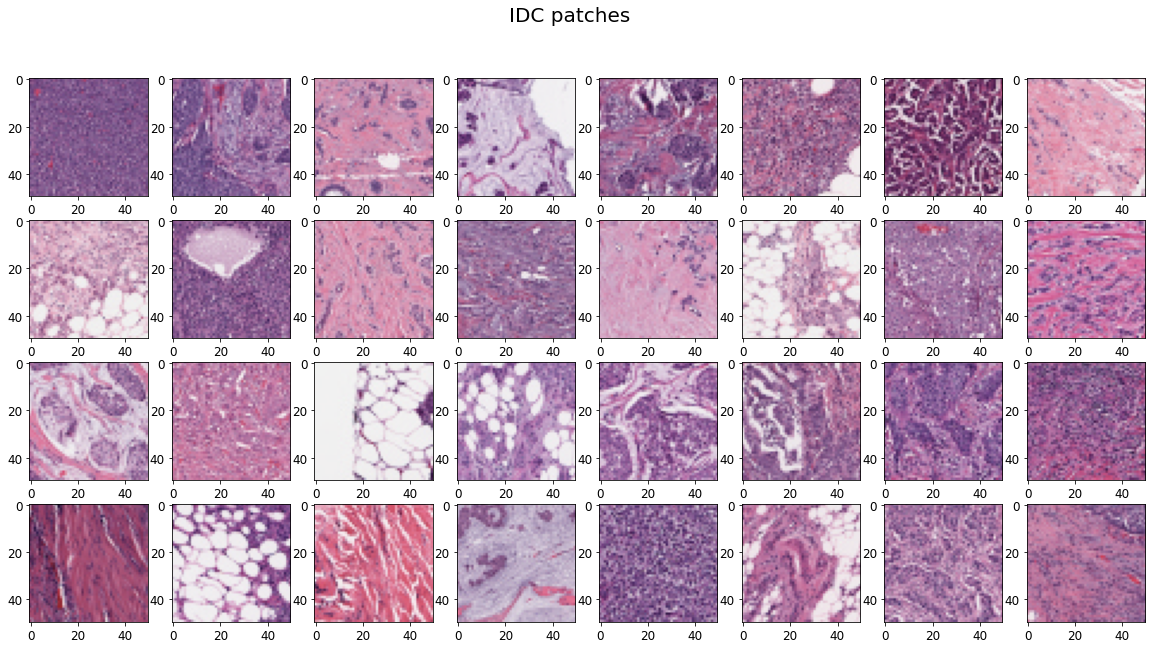

In [11]:
# IDC patches
fig, ax = plt.subplots(4, 8, figsize=(20, 10))

for i in range(4):
    for j in range(8):
        idx = idc_sample[j + 8*i]
        image = imread(data.loc[idx, 'path'])
        ax[i,j].imshow(image)
        
fig.suptitle('IDC patches', fontsize=20)
plt.show()

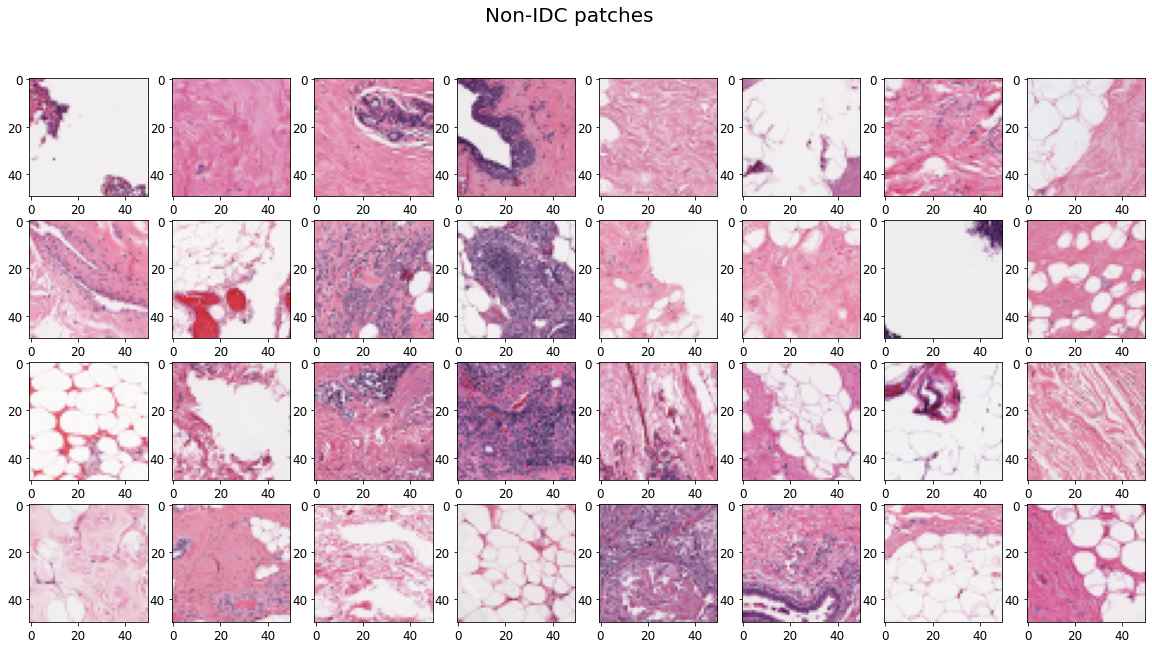

In [12]:
# Non-IDC patches
fig, ax = plt.subplots(4, 8, figsize=(20, 10))

for i in range(4):
    for j in range(8):
        idx = non_idc_sample[j + 8*i]
        image = imread(data.loc[idx, 'path'])
        ax[i,j].imshow(image)
        
fig.suptitle('Non-IDC patches', fontsize=20)
plt.show()

#### Show full IDC/Non-IDC patches using scatter plot

In [13]:
def scatter_plot_by_patient_id(patient_id):
    df = data[data.patient_id == patient_id]
    
    g = sns.scatterplot(data=df, x="x", y="y", hue="target")
    g.set_title('Patient: ' + str(patient_id), fontsize=20)
    g.grid()

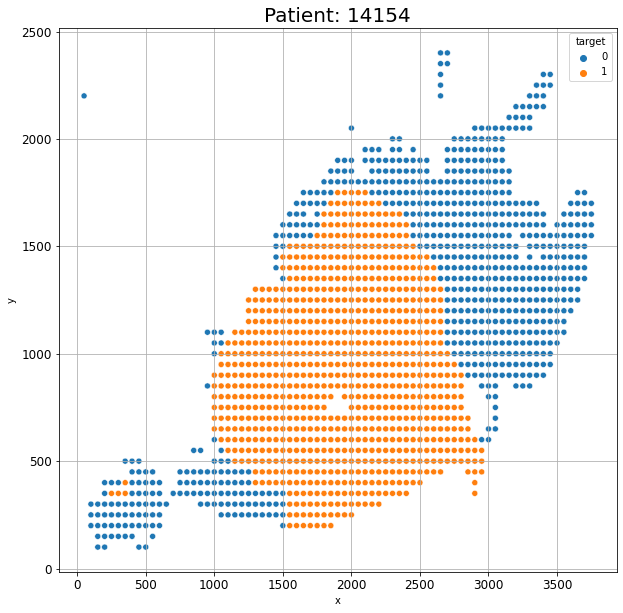

In [14]:
scatter_plot_by_patient_id(14154)

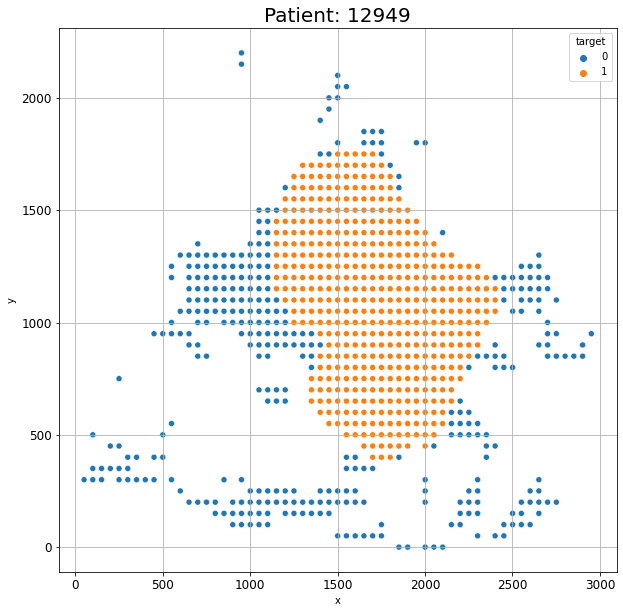

In [15]:
scatter_plot_by_patient_id(12949)

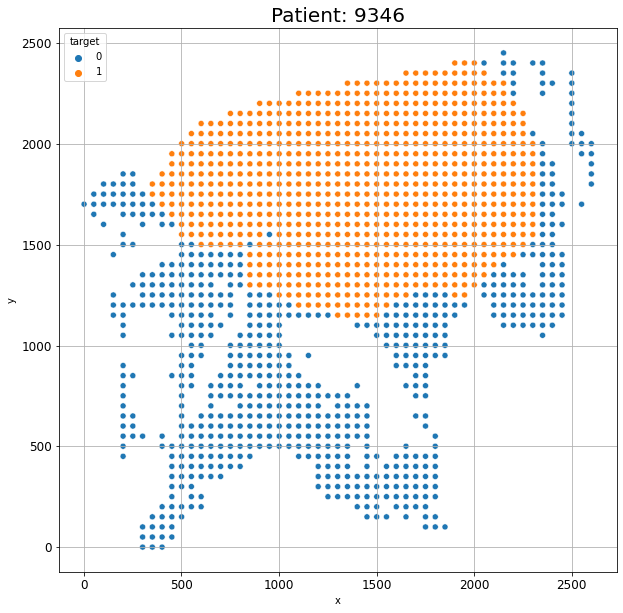

In [16]:
scatter_plot_by_patient_id(9346)

### 4.4. Setting the training set and test set

#### Create Training set/ Validation set/ Test set

In [17]:
train_set, val_test = train_test_split(data, test_size=0.3, random_state=0)
valid_set, test_set = train_test_split(val_test, test_size=0.5, random_state=0)

print('train/val/test: ' + str(len(train_set)) + '/' + str(len(valid_set)) + '/' + str(len(test_set)))

train/val/test: 194266/41629/41629


In [18]:
train_set.head(20)

,patient_id,x,y,path,target
120140,13023,1251,951,../dataset/13023/1/13023_idx5_x1251_y951_class1.png,1
61707,9322,2101,101,../dataset/9322/0/9322_idx5_x2101_y101_class0.png,0
134935,10268,3251,401,../dataset/10268/0/10268_idx5_x3251_y401_class0.png,0
43347,14191,1551,1401,../dataset/14191/0/14191_idx5_x1551_y1401_class0.png,0
156677,13024,1351,1251,../dataset/13024/0/13024_idx5_x1351_y1251_class0.png,0
8691,12886,1551,801,../dataset/12886/0/12886_idx5_x1551_y801_class0.png,0
259006,9259,301,2351,../dataset/9259/0/9259_idx5_x301_y2351_class0.png,0
99795,12905,1351,851,../dataset/12905/0/12905_idx5_x1351_y851_class0.png,0
11411,9321,651,1951,../dataset/9321/0/9321_idx5_x651_y1951_class0.png,0
144239,16896,1051,901,../dataset/16896/0/16896_idx5_x1051_y901_class0.png,0


#### Data Information

In [19]:
train_set.groupby("target")["target"].count()

target
0    139131
1     55135
Name: target, dtype: int64

In [20]:
valid_set.groupby("target")["target"].count()

target
0    29774
1    11855
Name: target, dtype: int64

In [21]:
test_set.groupby("target")["target"].count()

target
0    29833
1    11796
Name: target, dtype: int64

### 4.5. Load data into PyTorch tensors

In [23]:
import torch

from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

import h5py

In [24]:
class MyDataset(Dataset):
    def __init__(self, df_data, transform=None):
        super().__init__()
        self.df = df_data.values
        
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        _, _, _, img_path, label = self.df[index] # Only use path and target (not use patient_id, x, y)
        
        image = cv2.imread(img_path)
        image = cv2.resize(image, (50,50))
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [25]:
transforms = transforms.Compose([transforms.ToPILImage(), transforms.ToTensor()])

train = MyDataset(train_set, transforms)
valid = MyDataset(valid_set, transforms)
test = MyDataset(test_set, transforms)

In [26]:
train_data_gen = DataLoader(train, shuffle=True, batch_size=20000)
valid_data_gen = DataLoader(valid, batch_size=20000)
test_data_gen = DataLoader(test, batch_size=20000)

In [27]:
dataset_sizes = {
    'train':len(train_data_gen.dataset), 
    'valid':len(valid_data_gen.dataset), 
    'test':len(test_data_gen.dataset),
}

In [28]:
dataset_sizes

{'train': 194266, 'valid': 41629, 'test': 41629}

#### Convert image data to hdf5 format, dividing data into batches

In [29]:
def output_h5py(file_name, X, y):
    file = h5py.File(file_name, 'w')
    
    file.create_dataset('X', data=X)
    file.create_dataset('y', data=y)
    
    file.close()

In [30]:
i = 1

for (x, y) in train_data_gen:
    file_name = '../data_batch_train/X_train_' + str(i) + '.hdf5'
    output_h5py(file_name, x.numpy(), y.numpy())
    i += 1

In [31]:
i = 1

for (x, y) in valid_data_gen:
    file_name = '../data_batch_valid/X_valid_' + str(i) + '.hdf5'
    output_h5py(file_name, x.numpy(), y.numpy())
    i += 1

In [32]:
i = 1

for (x, y) in test_data_gen:
    file_name = '../data_batch_test/X_test_' + str(i) + '.hdf5'
    output_h5py(file_name, x.numpy(), y.numpy())
    i += 1

# 5. Final

- At the end of the implementation on the local machine, the output is batches of data, which will be the input of the deep learning system. 
- The deep learning system will be implemented on Google Colab.